#### Временные ряды и обработка сигналов. Лабораторная работа №3
|   Группа          |   Вариант         |   ФИО             |   
|   :------------:  |   :------------:  |   :------------:  |
|   М092501(71)     |   16 (1)          |   Шарибжанов И.Т. |

In [ ]:
%pip install prophet

In [2]:
# Импорт библиотек
import pandas as pd
import seaborn as sns
import datetime
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

sns.set_theme(style="whitegrid")

c:\Users\shari\YandexDisk\МТУСИ_МАГ_М092501(71)\1 семестр\Временные ряды\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [ ]:
# Чтение данных
data_by_week = pd.read_csv('data/1.data-n-4-8w.csv')
data_by_week

,time,people_amount
0,1.758499e+09,0
1,1.758499e+09,0
2,1.758499e+09,0
3,1.758499e+09,0
4,1.758499e+09,0
...,...,...
571445,1.761437e+09,0
571446,1.761437e+09,1
571447,1.761437e+09,0
571448,1.761437e+09,0


<Axes: xlabel='datetime', ylabel='people_amount'>

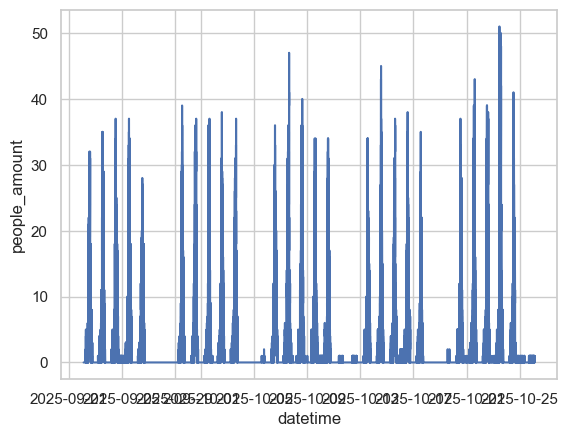

In [4]:
# Преобразование timestamp в datetime
data_by_week['time'] = data_by_week['time'].apply(lambda x: datetime.datetime.fromtimestamp(x))
data_by_week = data_by_week.rename(columns={'time': 'datetime'})

# Просмотр данных
sns.lineplot(x=data_by_week['datetime'], y=data_by_week['people_amount'])

In [5]:
# Подготовка данных для Prophet
# Переименовываем столбцы: datetime -> ds, people_amount -> y
data_by_week = data_by_week.rename(columns={'datetime': 'ds', 'people_amount': 'y'})
# Установка ds как индекса
data_by_week.set_index('ds', inplace=True)

In [6]:
# Ресэмплинг данных на часовые интервалы (среднее)
resampled_data = data_by_week.resample('H').mean().interpolate().fillna(0)
resampled_data.reset_index(inplace=True)

C:\Users\shari\AppData\Local\Temp\ipykernel_18764\1234727942.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled_data = data_by_week.resample('H').mean().interpolate().fillna(0)


In [7]:
#Добавляем floor=0 для всех моделей (чтобы прогнозы не были отрицательными)
resampled_data['floor'] = 0

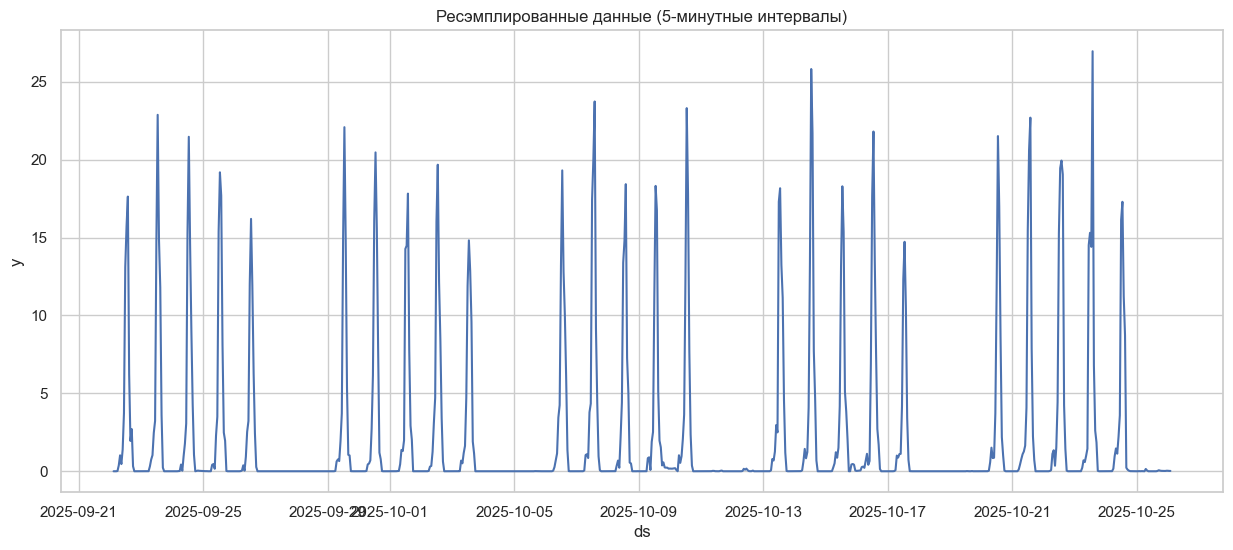

In [ ]:
# Визуализация ресэмплированных данных
plt.figure(figsize=(15, 6))
sns.lineplot(x=resampled_data['ds'], y=resampled_data['y'])
plt.title('Ресэмплированные данные (часовые интервалы)')
plt.show()

In [9]:
# Находим минимальную и максимальную даты
min_date = resampled_data['ds'].min()
max_date = resampled_data['ds'].max()
print(f'Диапазон данных: {min_date} - {max_date}')

Диапазон данных: 2025-09-22 03:00:00 - 2025-10-26 02:00:00


In [10]:
# Разделение по неделям: 3 недели = 21 день, 4 недели = 28 дней
three_weeks_end = min_date + pd.Timedelta(days=21)
four_weeks_end = min_date + pd.Timedelta(days=28)

train_3w = resampled_data[resampled_data['ds'] < three_weeks_end].copy()
train_full = resampled_data[resampled_data['ds'] < four_weeks_end].copy()
test_4w = resampled_data[(resampled_data['ds'] >= three_weeks_end) & (resampled_data['ds'] < four_weeks_end)].copy()

##### Параметры модели Prophet

В функции `create_model()` задаются общие настройки модели временного ряда:

- **`changepoint_prior_scale=0.05`** – регуляризация точек излома тренда. Управляет гибкостью тренда в модели Prophet — насколько легко модель допускает изломы тренда. Чем больше значение, тем **более гибко** модель подстраивается под изменения тренда (рискуя переобучиться). Чем меньше – тем **более гладкий** тренд, но возможна недообученность при резких изменениях.
- **`seasonality_mode='additive'`** – тип сезонности. Управляет тем, как сезонные колебания складываются с трендом в модели Prophet. Аддитивная сезонность предполагает, что вклад сезонных колебаний **не зависит от уровня** ряда (важно при наличии нулевых значений).
- **`daily_seasonality=False`** – отключение встроенной дневной сезонности по умолчанию (мы задаём её явно ниже через `add_seasonality`).
- **`weekly_seasonality=True`** – учёт **недельной сезонности** (повторяющиеся паттерны по дням недели).
- **`yearly_seasonality=False`** – отключение годовой сезонности, так как горизонт наблюдений слишком мал для адекватного захвата годовых паттернов.

Дополнительно задаётся собственная дневная сезонность:

- Вызов `model.add_seasonality(name='daily', period=1, fourier_order=10)` добавляет **кастомную дневную сезонность** с периодом в один день и достаточно гибким описанием суточного профиля за счёт `fourier_order=10` (что позволяет моделировать сложные внутрисуточные колебания).


In [ ]:
# Функция создания модели: общие настройки
def create_model():
    model = Prophet(
        changepoint_prior_scale=0.05,  # Оптимизация: чувствительность к изменениям (prev: 0.1)
        seasonality_mode='additive',   # Additive так как данные содержат нули (prev: multiplicative)
        daily_seasonality=False,       # Отключаем default (prev: True)
        weekly_seasonality=True,
        yearly_seasonality=False
    )
    # Custom daily seasonality с fourier_order=10 (для intra-day паттернов)
    model.add_seasonality(name='daily', period=1, fourier_order=10)
    return model

In [12]:
# 1. Обучение на всех 4 неделях и предсказание следующей недели
model_full = create_model()
model_full.fit(train_full)

11:33:50 - cmdstanpy - INFO - Chain [1] start processing
11:33:50 - cmdstanpy - INFO - Chain [1] done processing


**Кросс‑валидация** – это способ оценить качество модели на данных, которые она раньше не видела, то есть проверить, насколько хорошо модель будет предсказывать будущее, а не только «запоминать» обучающую выборку.

В контексте Prophet это особенно важно, потому что:
- модель легко подстраивается под тренды и сезонности,
- нам нужно понять, как она ведёт себя при прогнозе вперёд на реальный горизонт (7 дней в твоём коде).

In [27]:
# Кросс-валидация для оценки модели
df_cv_full = cross_validation(model_full, initial='14 days', period='7 days', horizon='7 days')  # Адаптировано для данных
df_p_full = performance_metrics(df_cv_full)
print("Кросс-валидация для модели на 4 неделях:")
print(df_p_full)

  0%|          | 0/1 [00:00<?, ?it/s]11:39:11 - cmdstanpy - INFO - Chain [1] start processing
11:39:11 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


Кросс-валидация для модели на 4 неделях:
            horizon        mse      rmse       mae     mdape     smape  \
0   0 days 16:00:00   5.169165  2.273580  1.365652  0.381094  0.713324   
1   0 days 17:00:00   5.272754  2.296248  1.434980  0.381094  0.713324   
2   0 days 18:00:00   5.387858  2.321176  1.515866  0.381094  0.713324   
3   0 days 19:00:00   5.489546  2.342978  1.586850  0.381094  0.717896   
4   0 days 20:00:00   5.625822  2.371882  1.677448  0.381094  0.819023   
..              ...        ...       ...       ...       ...       ...   
148 6 days 20:00:00  20.185301  4.492805  2.908891       inf  1.998899   
149 6 days 21:00:00  19.994854  4.471561  2.836997       inf  1.998899   
150 6 days 22:00:00  19.713790  4.440021  2.727470       inf  1.998899   
151 6 days 23:00:00  19.591927  4.426277  2.664352       inf  1.998899   
152 7 days 00:00:00  19.550725  4.421620  2.623679       inf  1.998899   

     coverage  
0      0.8125  
1      0.8125  
2      0.8125  
3     

Это **time series‑кросс‑валидация с «скользящим окном»** (rolling/expanding origin):
- **initial='14 days'**.
Первое «обучающее окно» длится 14 дней. Модель обучается на первых 14 днях данных, затем делает прогноз на следующие 7 дней (horizon).

- **horizon='7 days'**.
Это длина прогнозируемого отрезка в каждом шаге кросс‑валидации – то, что нас реально интересует (прогноз на неделю вперёд). Prophet предсказывает значения на 7 дней вперёд, и эти предсказания сравниваются с фактическими данными.

- **period='7 days'**. Это шаг, с которым происходит сдвиг окна. После первой итерации граница обучения сдвигается на 7 дней вперёд: сначала: train = первые 14 дней → прогноз на дни 15–21, потом: train = первые 21 день → прогноз на дни 22–28, и так далее, пока хватает данных.

Таким образом, мы получаем несколько независимых «экспериментов» прогноза на 7 дней, в разных местах временного ряда.

Результат cross_validation – таблица с предсказаниями и истинными значениями на всех этих отрезках; затем `performance_metrics(df_cv_full)` считает по ним метрики (MSE, RMSE, MAE, SMAPE, coverage).

In [14]:
# Прогноз на следующую неделю (168 часов = 7 дней)
future_full = model_full.make_future_dataframe(periods=168, freq='H')
future_full['floor'] = 0
forecast_full = model_full.predict(future_full)

c:\Users\shari\YandexDisk\МТУСИ_МАГ_М092501(71)\1 семестр\Временные ряды\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


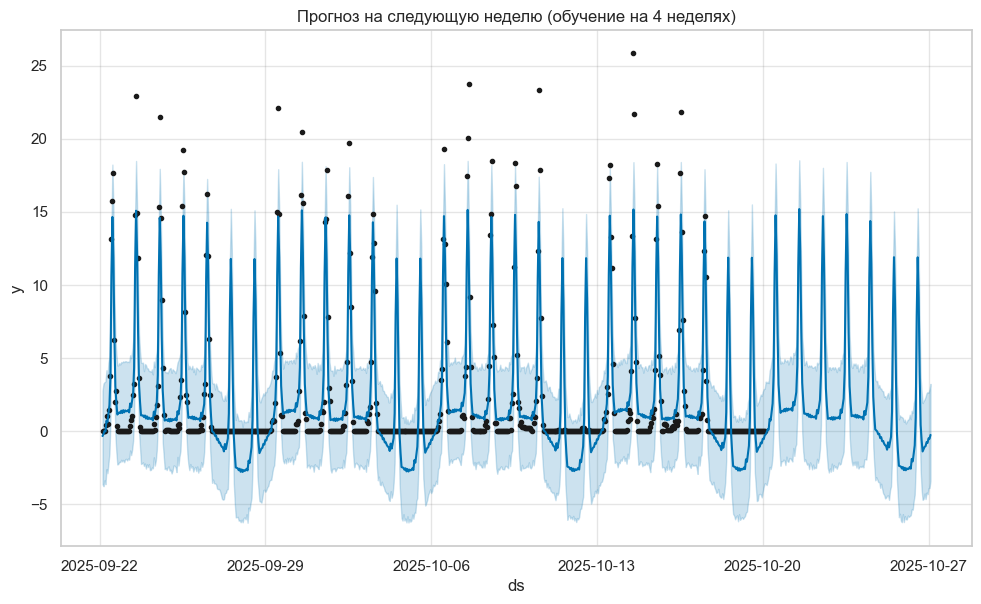

In [15]:
# Plot прогноза
fig1 = model_full.plot(forecast_full)
plt.title('Прогноз на следующую неделю (обучение на 4 неделях)')
plt.show()

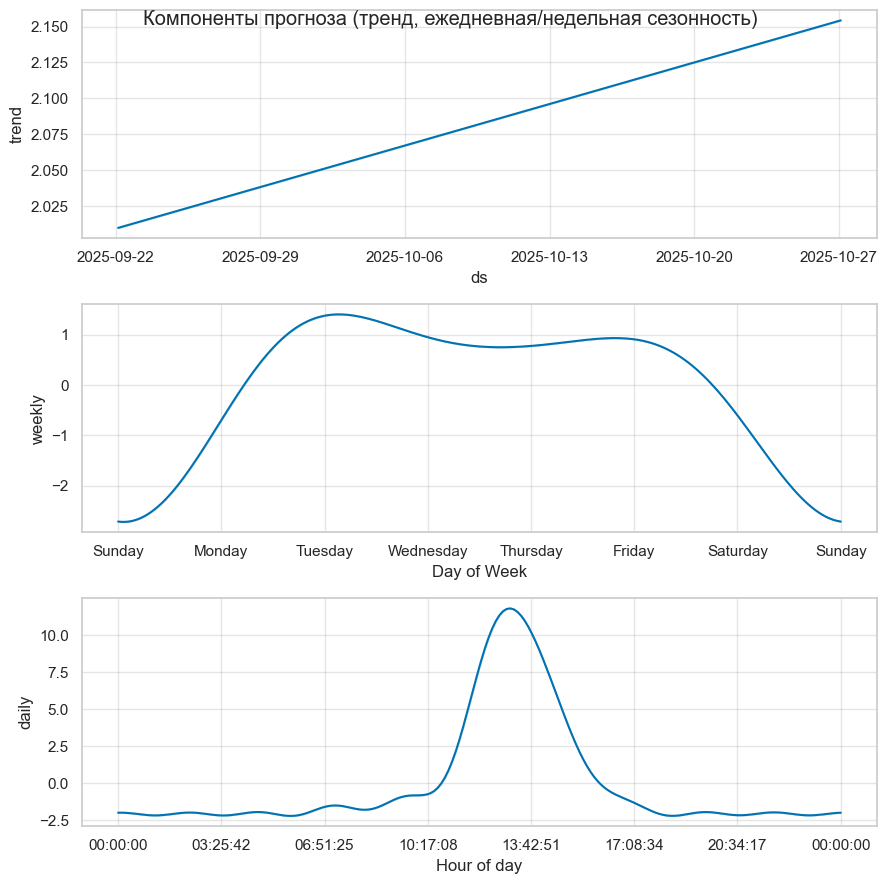

In [16]:
# Plot компонентов
fig2 = model_full.plot_components(forecast_full)
plt.suptitle('Компоненты прогноза (тренд, ежедневная/недельная сезонность)')
plt.show()

In [17]:
# 2. Модель на 3 неделях, предсказание 4-й недели (7 дней)
model_3w = create_model()
model_3w.fit(train_3w)

11:33:52 - cmdstanpy - INFO - Chain [1] start processing
11:33:52 - cmdstanpy - INFO - Chain [1] done processing


In [26]:
# Кросс-валидация для 3w модели
df_cv_3w = cross_validation(model_3w, initial='10 days', period='5 days', horizon='7 days')  # Адаптировано
df_p_3w = performance_metrics(df_cv_3w)
print("Кросс-валидация для модели на 3 неделях:")
print(df_p_3w)

  0%|          | 0/1 [00:00<?, ?it/s]11:37:17 - cmdstanpy - INFO - Chain [1] start processing
11:37:18 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Кросс-валидация для модели на 3 неделях:
            horizon        mse      rmse       mae        mdape     smape  \
0   0 days 16:00:00   4.030283  2.007557  1.347778     0.499648  0.894685   
1   0 days 17:00:00   4.073027  2.018174  1.381818     0.499648  0.894685   
2   0 days 18:00:00   4.143427  2.035541  1.431798     0.499648  0.894685   
3   0 days 19:00:00   4.197009  2.048660  1.487586     0.499648  0.894685   
4   0 days 20:00:00   4.280926  2.069040  1.549828     0.499648  0.894685   
..              ...        ...       ...       ...          ...       ...   
148 6 days 20:00:00  19.012610  4.360345  2.933579  2197.130516  1.944316   
149 6 days 21:00:00  18.799657  4.335857  2.865871  2197.130516  1.944316   
150 6 days 22:00:00  18.481862  4.299054  2.762543          inf  1.944316   
151 6 days 23:00:00  18.317844  4.279935  2.697201          inf  1.944316   
152 7 days 00:00:00  18.250003  4.272002  2.656978          inf  1.944316   

     coverage  
0      0.8125  
1 

In [19]:
# Прогноз на 4-ю неделю (длина = 168 часов)
future_3w = model_3w.make_future_dataframe(periods=168, freq='H')
future_3w['floor'] = 0
forecast_3w = model_3w.predict(future_3w)

c:\Users\shari\YandexDisk\МТУСИ_МАГ_М092501(71)\1 семестр\Временные ряды\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


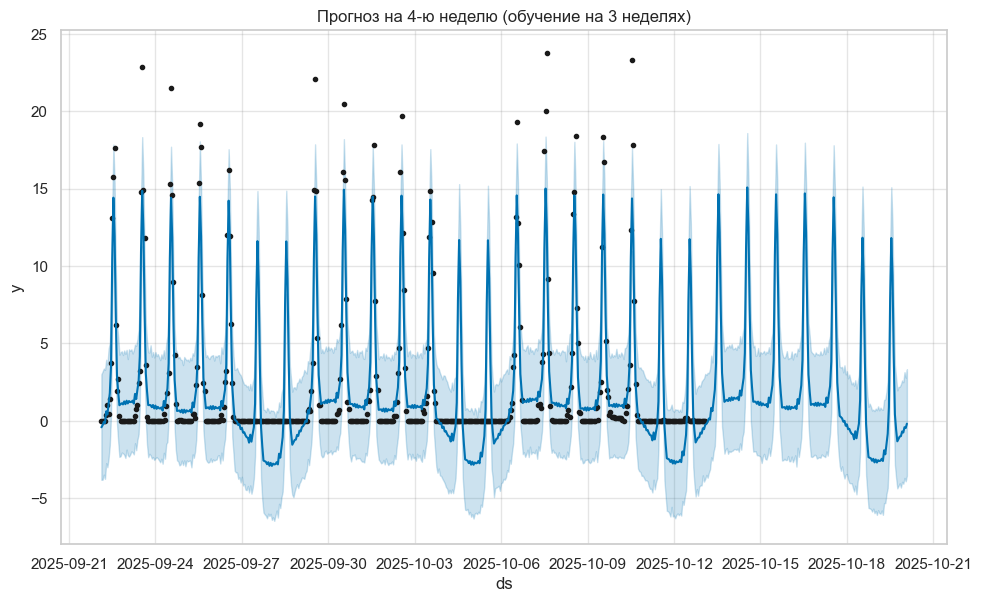

In [20]:
# Plot прогноза
fig3 = model_3w.plot(forecast_3w)
plt.title('Прогноз на 4-ю неделю (обучение на 3 неделях)')
plt.show()

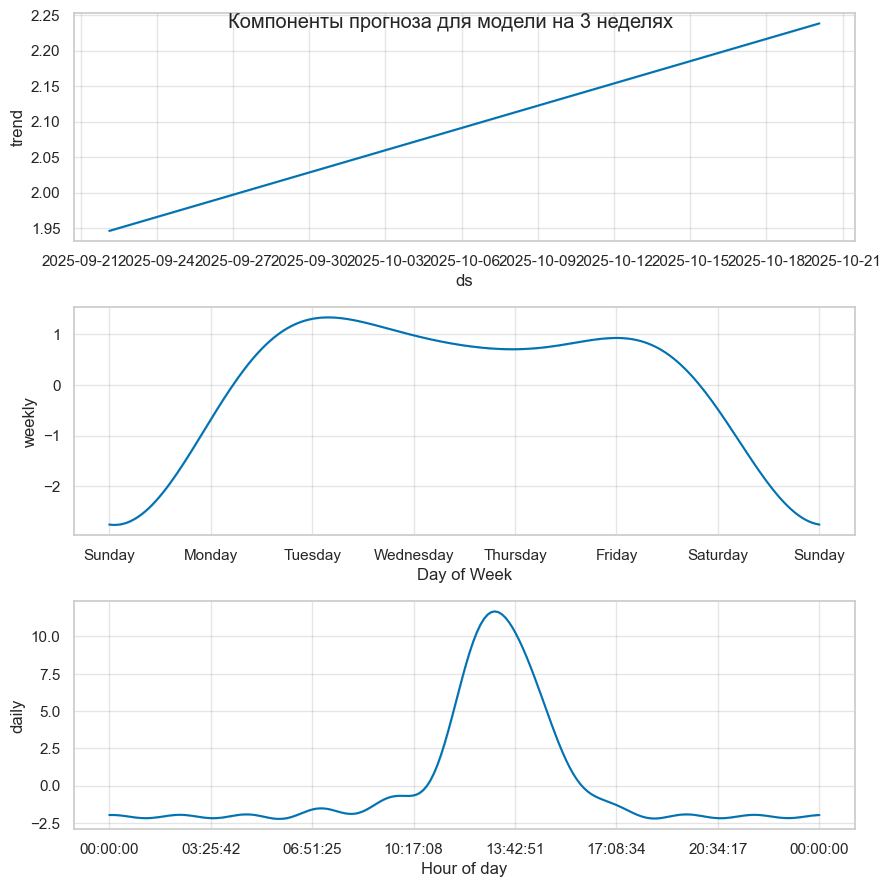

In [21]:
# Plot компонентов
fig4 = model_3w.plot_components(forecast_3w)
plt.suptitle('Компоненты прогноза для модели на 3 неделях')
plt.show()

In [22]:
# 3. Сравнение качества (out-of-sample для 3w, in-sample для full на той же 4-й неделе)
# Выделяем предсказания для периода test_4w (7 дней)
forecast_3w_pred = forecast_3w[forecast_3w['ds'].isin(test_4w['ds'])]
forecast_full_4w = forecast_full[forecast_full['ds'].isin(test_4w['ds'])]

In [23]:
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-10))

In [24]:
# Метрики для 3w модели (out-of-sample)
mae_3w = mean_absolute_error(test_4w['y'], forecast_3w_pred['yhat'])
rmse_3w = np.sqrt(mean_squared_error(test_4w['y'], forecast_3w_pred['yhat']))
smape_3w = smape(test_4w['y'], forecast_3w_pred['yhat'])
print(f'Для модели на 3 неделях (out-of-sample на 4-й неделе): MAE = {mae_3w:.2f}, RMSE = {rmse_3w:.2f}, SMAPE = {smape_3w:.2f}%')

Для модели на 3 неделях (out-of-sample на 4-й неделе): MAE = 1.68, RMSE = 2.73, SMAPE = 141.52%


In [ ]:
# Метрики для full модели (in-sample на 4-й неделе)
mae_full = mean_absolute_error(test_4w['y'], forecast_full_4w['yhat'])
rmse_full = np.sqrt(mean_squared_error(test_4w['y'], forecast_full_4w['yhat']))
smape_full = smape(test_4w['y'], forecast_full_4w['yhat'])
print(f'Для модели на 4 неделях (in-sample на 4-й неделе): MAE = {mae_full:.2f}, RMSE = {rmse_full:.2f}, SMAPE = {smape_full:.2f}%')

Для модели на 4 неделях (in-sample на 4-й неделе): MAE = 1.67, RMSE = 2.71, SMAPE = 140.70%


##### Метрики качества прогноза

**`MAE` (Mean Absolute Error – средняя абсолютная ошибка)**
  - **Показывает** на сколько единиц в среднем модель ошибается в прогнозе (в тех же единицах, что и сам ряд).  
  - Чем **меньше MAE**, тем в среднем ближе прогноз к реальности.

**`RMSE` (Root Mean Squared Error – корень из среднеквадратичной ошибки)**
  - **Показывает** среднюю ошибку, но **сильнее штрафует крупные промахи**, так как ошибка возводится в квадрат.

**`SMAPE` (Symmetric Mean Absolute Percentage Error – симметричная средняя абсолютная процентная ошибка)**
  - **Показывает** насколько в среднем прогноз отличается от реальности **в процентах**, симметрично для завышений и занижений